<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch09_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- CIFAR-10を従来型の機械学習モデルで予測しようとすると、頑張っても40%程度の精度しか出ない
- CNN
    - 畳み込み
        - 3x3 や 5x5 などのサイズのカーネルを用意する
            - この画素数は奇数(3や5など)にするのが普通
        - 積和演算は全チャネルにまたがって行われる
            - カーネルもそれに対応して入力チャネル分ある
        - さらに出力チャネルも複数あるため、カーネルは全体で4階テンソル構造をもつ
        - 位置によらない特徴量を抽出
    - Max Pooling
        - 矩形領域のサイズは2x2が多い
        - タテヨコともに元の画像の半分の画素数の新しい画像ができるイメージ
        - 大きさによらない特徴量を抽出
    - 固定長のカーネル行列を用意しておくだけなので、どんな大きさの入力でも受け取れる


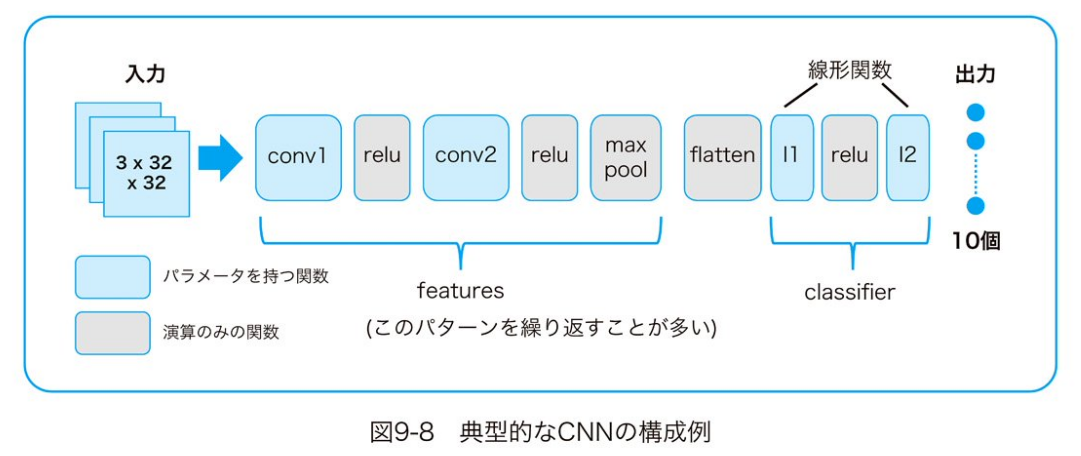

In [1]:
import torch.nn as nn

In [2]:
# レイヤー関数の定義確認
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

In [3]:
print(conv1.weight.shape)
print(conv1.bias.shape)
print(conv2.weight.shape)
print(conv2.bias.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


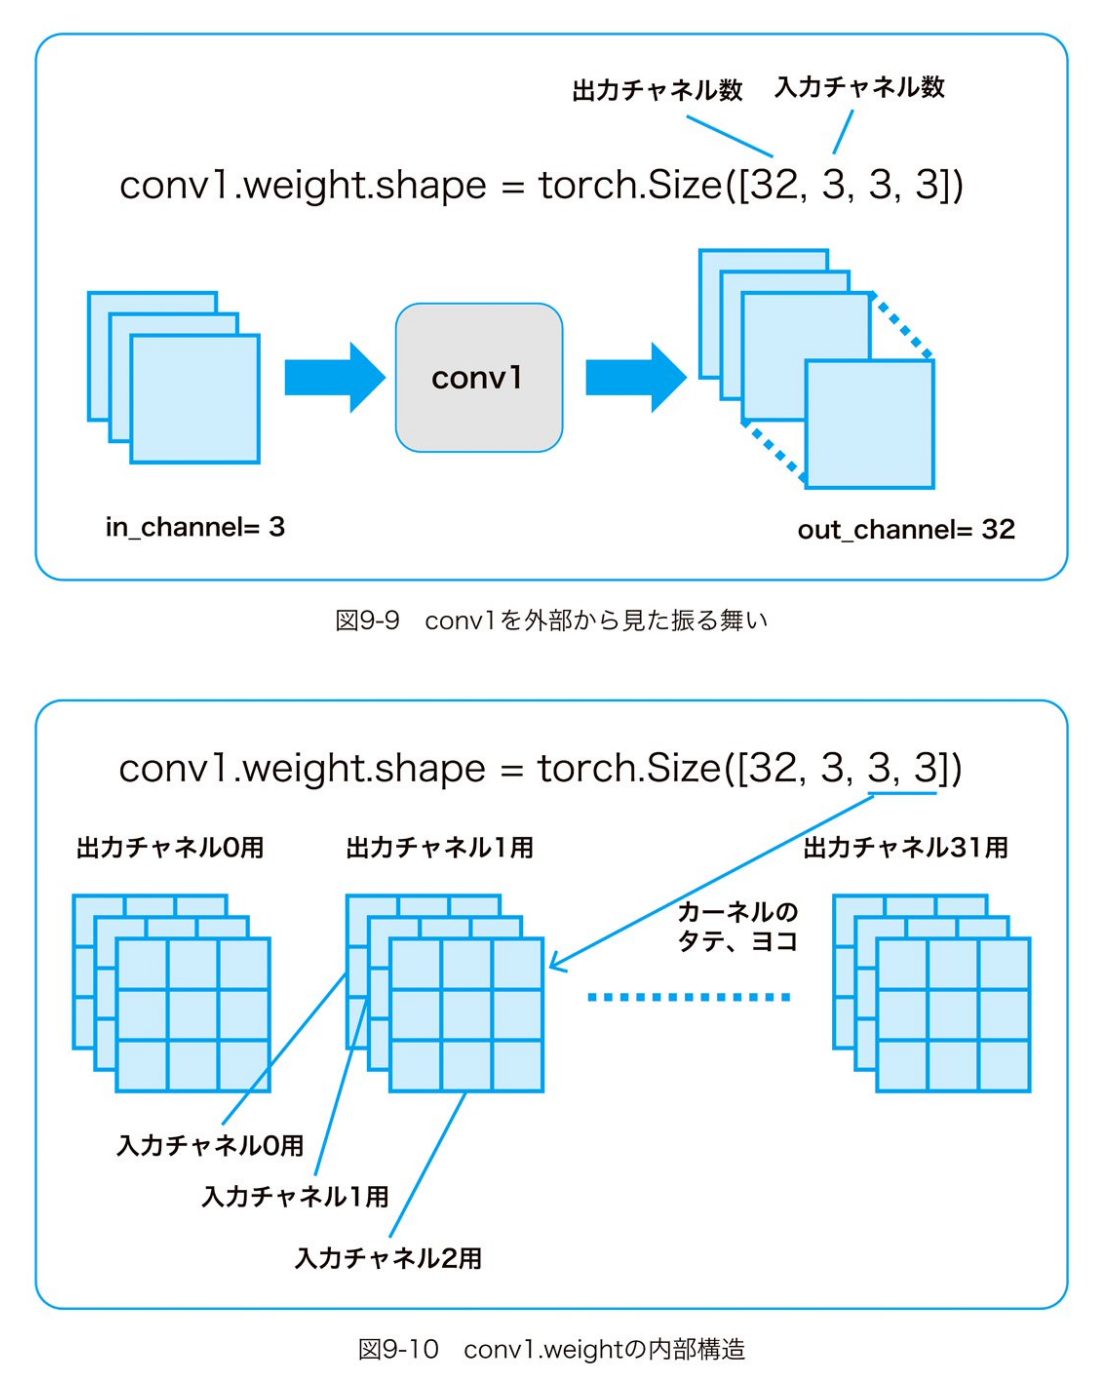

- 出力チャネル1つにつき、入力チャネル3枚すべてについて、積和演算を3回やる。その結果をすべて加算したものが出力チャネル1個分となる
    - 「加算」とは入力チャネル方向に
- 要は、 3x3のカーネルが、入力チャネル数x出力チャネル数分、存在する

In [4]:
import torch

In [5]:
# ダミーでCIFAR10の入力と同じサイズのテンソルを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [6]:
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [7]:
# conv1もconv2も出力チャネル数は32
# conv1: 32 -> 30(カーネルサイズ3 - 1 = 2 だけサイズが減少)
print(x1.shape)
print(x2.shape)
# conv2: 30 -> 28 同上
print(x3.shape)
print(x4.shape)
# maxpool: 重ならないように矩形領域をずらすので、矩形領域の2で割ったサイズになる
print(x5.shape)

torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [8]:
from torch.utils.data import DataLoader

In [9]:
# 共通関数定義
# 損失計算
def eval_loss(
    loader: DataLoader,
    device: torch.DeviceObjType,
    net: nn.Module,
    criterion: nn.modules.loss._Loss
):
    # データローダーから1セット取得
    for images, labels in loader:
        break
    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

In [10]:
import numpy as np

In [11]:
# 学習用関数
def fit(
    net,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
):
    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        # ドロップアウト関数やバッチ正規化関数で「今は訓練フェーズ」「今は予測フェーズ」という違いを明示することが必要
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size

            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [12]:
import matplotlib.pyplot as plt

In [13]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [14]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [15]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

# 9.6 データ準備

In [16]:
import torchvision.transforms as transforms

In [17]:
# 正規化のみ実施するTransform
transform2 = transforms.Compose([
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
])

In [18]:
import torchvision.datasets as datasets

In [19]:
import torch.optim as optim

In [20]:
data_root = "./data"

# 訓練データ 3階テンソル版
train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform2,
)
# 検証データ 3階テンソル版
test_set2 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform2,
)

100%|██████████| 170498071/170498071 [00:10<00:00, 15711368.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [21]:
image2, label2 = train_set2[0]
print(image2.shape)

torch.Size([3, 32, 32])


In [22]:
# データローダー定義
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [23]:
for images2, labels2 in train_loader2:
    break
print(images2.shape)

torch.Size([100, 3, 32, 32])


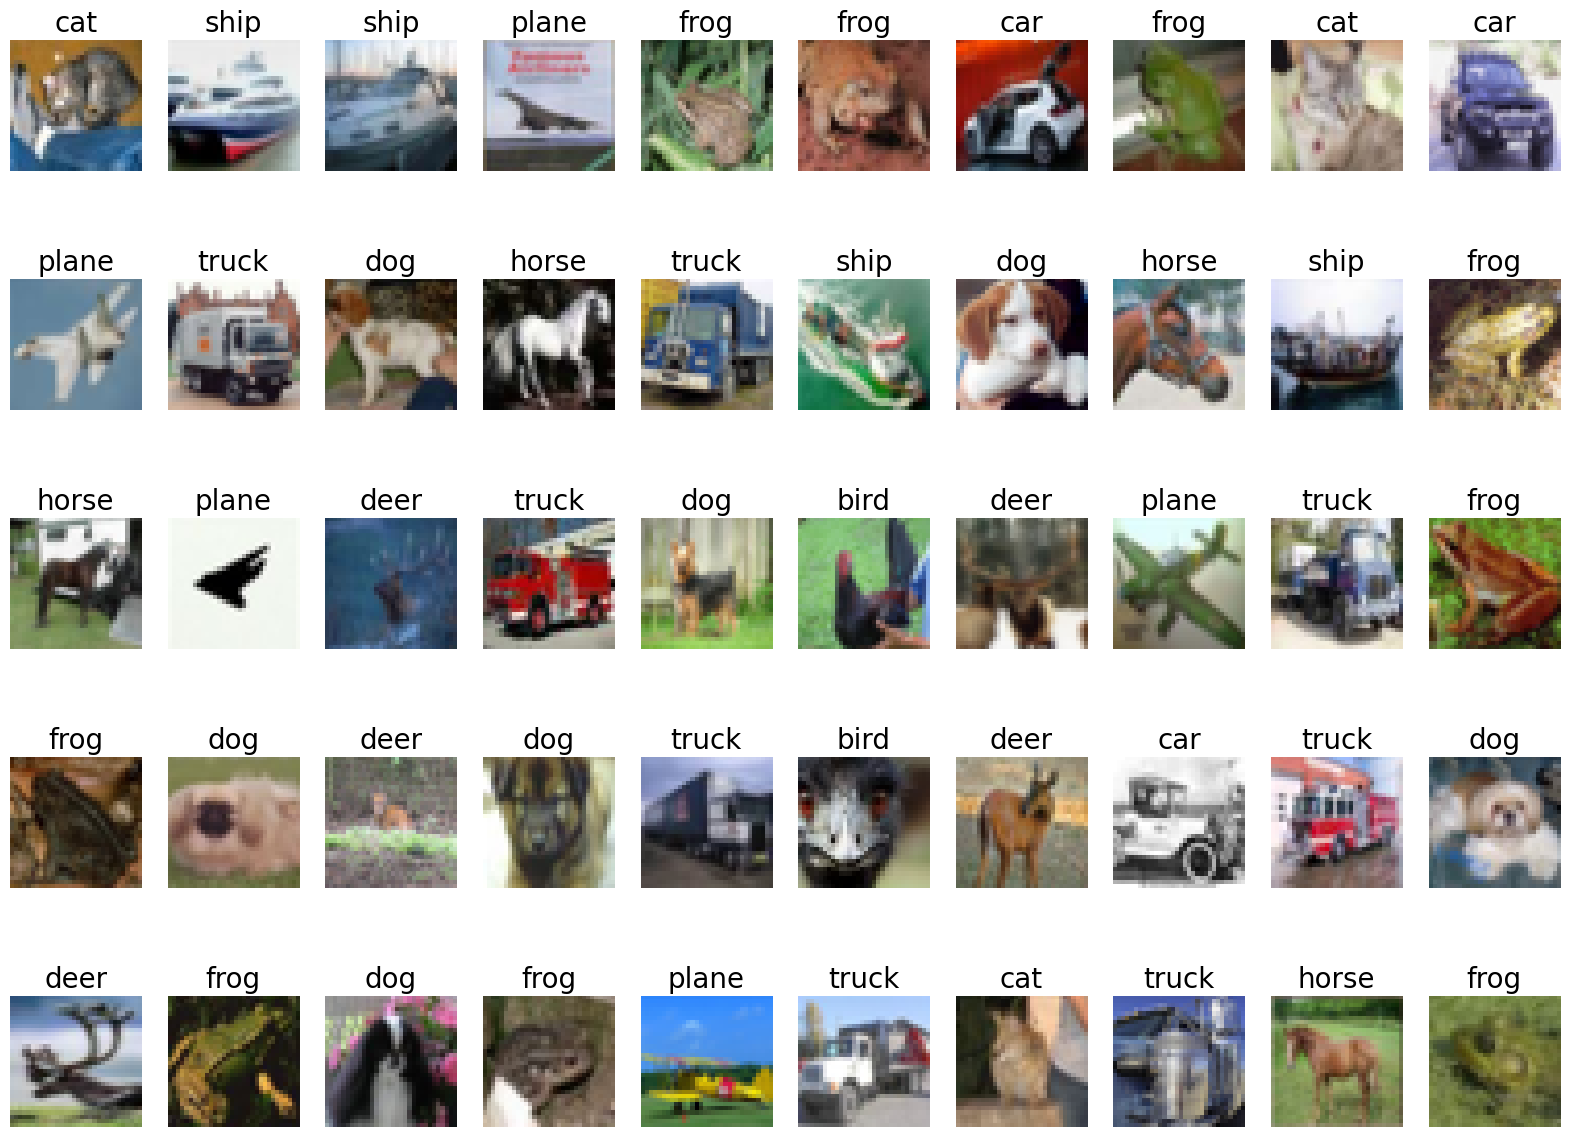

In [24]:
# test_loader2 から50個のイメージを表示してみる
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

show_images_labels(
    loader=test_loader2,
    classes=classes,
    net=None,
    device=None,
)

In [25]:
# モデル定義
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        # maxpool の結果 (32, 14, 14) -> 32*14*14 = 6272
        self.l1 = nn.Linear(in_features=6272, out_features=n_hidden)
        self.l2 = nn.Linear(in_features=n_hidden, out_features=n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [26]:
!pip install torchinfo | tail -n 1
from torchinfo import summary

In [27]:
n_output = 10
n_hidden = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch_seed()
net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 50
history2 = np.zeros((0, 5))
history2 = fit(
    net,
    optimizer,
    criterion,
    num_epochs,
    train_loader2,
    test_loader2,
    device,
    history2
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08247 acc: 0.26104 val_loss: 1.86607, val_acc: 0.34680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.78092 acc: 0.37282 val_loss: 1.67717, val_acc: 0.40960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.61337 acc: 0.43034 val_loss: 1.53014, val_acc: 0.46020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48540 acc: 0.47316 val_loss: 1.45016, val_acc: 0.48920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.40820 acc: 0.49958 val_loss: 1.37012, val_acc: 0.51190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.34995 acc: 0.52032 val_loss: 1.33319, val_acc: 0.52670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.30375 acc: 0.53648 val_loss: 1.29221, val_acc: 0.53810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.25327 acc: 0.55444 val_loss: 1.25464, val_acc: 0.55040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.20572 acc: 0.57406 val_loss: 1.23699, val_acc: 0.56150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.15814 acc: 0.59128 val_loss: 1.18471, val_acc: 0.58130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.11632 acc: 0.60852 val_loss: 1.16359, val_acc: 0.58880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.07762 acc: 0.62366 val_loss: 1.17237, val_acc: 0.58210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.03576 acc: 0.63748 val_loss: 1.11236, val_acc: 0.60600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.99734 acc: 0.65058 val_loss: 1.08895, val_acc: 0.61400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.95897 acc: 0.66442 val_loss: 1.10911, val_acc: 0.60420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.92158 acc: 0.67736 val_loss: 1.05239, val_acc: 0.63310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.88123 acc: 0.69292 val_loss: 1.05917, val_acc: 0.62680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.84567 acc: 0.70416 val_loss: 1.01089, val_acc: 0.64970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.80773 acc: 0.71932 val_loss: 1.01863, val_acc: 0.64220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.77272 acc: 0.73156 val_loss: 1.04698, val_acc: 0.63290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.73743 acc: 0.74306 val_loss: 1.00286, val_acc: 0.65560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.70083 acc: 0.75794 val_loss: 1.02284, val_acc: 0.65170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.67381 acc: 0.76642 val_loss: 0.99496, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.63638 acc: 0.77964 val_loss: 1.00476, val_acc: 0.66190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.60329 acc: 0.79354 val_loss: 1.00520, val_acc: 0.66770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.56806 acc: 0.80552 val_loss: 1.05111, val_acc: 0.64770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.53910 acc: 0.81632 val_loss: 1.05043, val_acc: 0.66360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.50821 acc: 0.82704 val_loss: 1.12920, val_acc: 0.64340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47410 acc: 0.83938 val_loss: 1.05214, val_acc: 0.66780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.44244 acc: 0.85192 val_loss: 1.11535, val_acc: 0.65470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.40787 acc: 0.86310 val_loss: 1.09335, val_acc: 0.66650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.38000 acc: 0.87168 val_loss: 1.19018, val_acc: 0.64340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.35174 acc: 0.88442 val_loss: 1.12479, val_acc: 0.66860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32431 acc: 0.89232 val_loss: 1.22103, val_acc: 0.65490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.29435 acc: 0.90590 val_loss: 1.26508, val_acc: 0.65370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.27335 acc: 0.91166 val_loss: 1.25907, val_acc: 0.65610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.24092 acc: 0.92468 val_loss: 1.28792, val_acc: 0.65980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.21475 acc: 0.93400 val_loss: 1.32935, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.19623 acc: 0.94010 val_loss: 1.36841, val_acc: 0.66200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.17315 acc: 0.95072 val_loss: 1.44667, val_acc: 0.65340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.14725 acc: 0.95962 val_loss: 1.56734, val_acc: 0.65220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.12991 acc: 0.96538 val_loss: 1.55370, val_acc: 0.65100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.10604 acc: 0.97508 val_loss: 1.56184, val_acc: 0.66010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.10236 acc: 0.97636 val_loss: 1.58630, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.09023 acc: 0.98114 val_loss: 1.62973, val_acc: 0.66530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.06082 acc: 0.98958 val_loss: 1.70515, val_acc: 0.65710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04559 acc: 0.99420 val_loss: 1.74420, val_acc: 0.66550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03601 acc: 0.99638 val_loss: 1.78706, val_acc: 0.66530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02910 acc: 0.99784 val_loss: 1.86817, val_acc: 0.66210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02439 acc: 0.99850 val_loss: 1.88657, val_acc: 0.66490


初期状態: 損失: 1.86607 精度: 0.34680
最終状態: 損失: 1.88657 精度: 0.66490


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

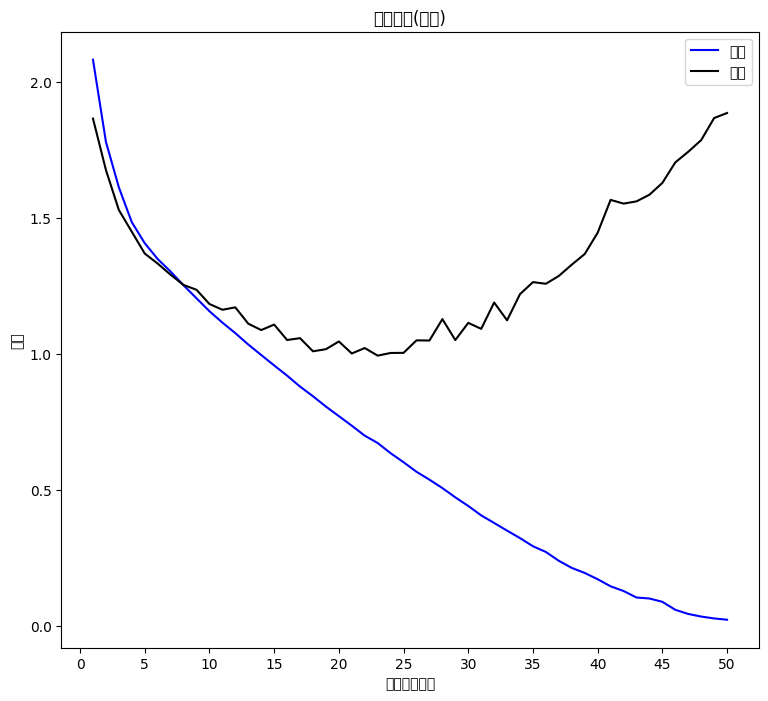

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


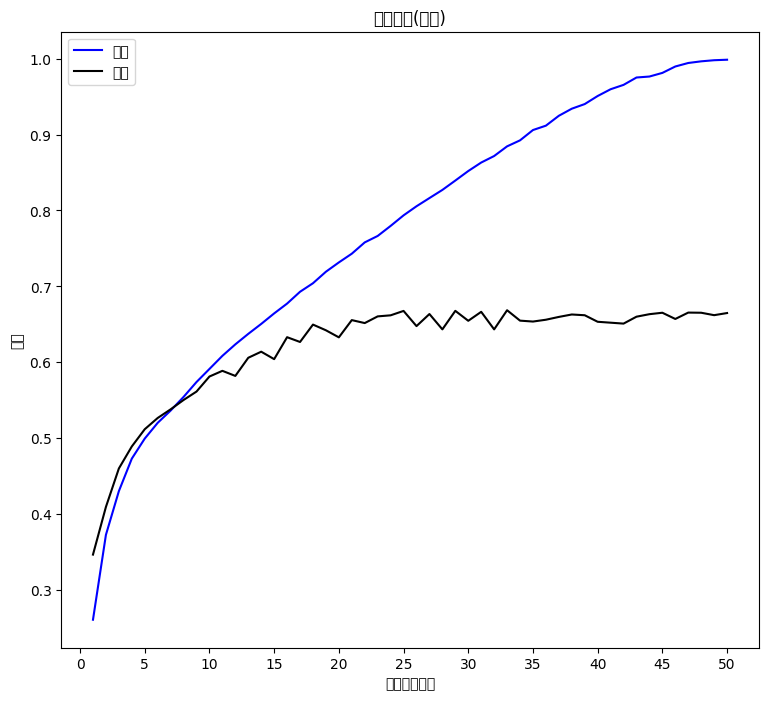

In [28]:
evaluate_history(history2)